# Filtrado de señales

In [1]:
import os, datetime
import numpy as np
import matplotlib.pyplot as plt

root_folder = os.path.join('..','..')

In [2]:
# Los datos del SMN tienen dos columnas de encabezado, hay que leer con cuidado, 
# parece estar hecho en un encoding traido de windows.
# Los archivos parecen tener ancho de columnas fijas
def read_fixed_columns_file(filename, widths, n_heads):
    '''
    Se deben proveer las posiciones de comienzo de las diferentes columnas, salvo la ultima
    Por ejemplo: para un archivo con dos columnas cuyos anchos sean 5 caracteres y 10
                widths = [0,5]
    n_heads: Numero de lineas de encabezado
    '''
    assert type(widths) == type([])
    with open(filename, 'rb') as fp:
        headers = []
        for i in range(n_heads):
            headers.append(next(fp).decode(errors='replace').split()) # elimino errores de codificación
        raw_data = []
        for line in fp:
            lines = line.decode(errors='replace')

            raw_data.append(
                [lines[widths[i]:widths[i+1]].strip() for i in range(len(widths)-1)]
                )
    return headers, raw_data

def clean_raw(raw_data):
    '''
    Como los archivos tienen varios problemas, esta función va desarrollandose a medida que
    tales problemas aparecen. Por ahora se observa que existen saltos de carro en algunas lineas
    de los archivos de texto
    '''
    # limpiando las columnas con salto de carro
    clean = []
    for l in raw_data:
        if l[0] != '':
            clean.append(l)
    # reemplazando los strings vacíos por -1 
    for l in range(len(clean)):
        for it in range(len(clean[l])):
            if clean[l][it] == '':
                clean[l][it] = '-1' # Controlando los datos vacíos

    return clean

In [3]:
data_folder = os.path.join(root_folder, 'Data', 'junio-SMN','horario')
# Leemos toda la carpeta
raw_data = []
for f in os.listdir(data_folder):
    headers, data = read_fixed_columns_file(os.path.join(data_folder, f),
                        widths=[0,8,14,20,25,33,38,43,1000],
                        n_heads=2)
    raw_data.append(clean_raw(data))

In [4]:
data_fmttd = []
for day in raw_data:
    for d in day:
        # Since data is not very well structured and a lot of carriage return appear
        if len(d) > 7:
            data_fmttd.append({
                'timestamp': datetime.datetime.strptime(d[0],'%d%m%Y')+ datetime.timedelta(hours= int(d[1])),
                'temp': float(d[2]),
                'hum': float(d[3]),
                'pres': float(d[4]),
                'v_direcc': float(d[5])%360, # modulo function to put data into one cycle
                'v_intens': float(d[6]),
                'estac': d[7]
            }
            )
# Imprimimos un dato de ejemplo y sacamos los labels
labels = []
for k,v in data_fmttd[123].items():
    print(f'{k}: {v}')
    labels.append(k)
labels = labels[1:-1] # no necesitamos los timestamps ni la estacion

timestamp: 2023-06-14 03:00:00
temp: -16.2
hum: 85.0
pres: 1002.8
v_direcc: 230.0
v_intens: 31.0
estac: BASE MARAMBIO


In [5]:
time_salta = []
data_salta = []
for element in data_fmttd:
    if element['estac'].find('SALTA') >= 0:
        time_salta.append(element['timestamp'])
        data_salta.append([
            element['temp'], 
            element['hum'], 
            element['pres'], 
            element['v_direcc'], 
            element['v_intens']])
# hacemos arrays de numpy con las listas y las ordenamos en el tiempo
time_salta = np.array(time_salta)
idx_sorted = np.argsort(time_salta)
time_salta = time_salta[idx_sorted]
data_salta = np.array(data_salta)[idx_sorted]
data_salta_temp = data_salta[:,0]

## Covarianza

[]

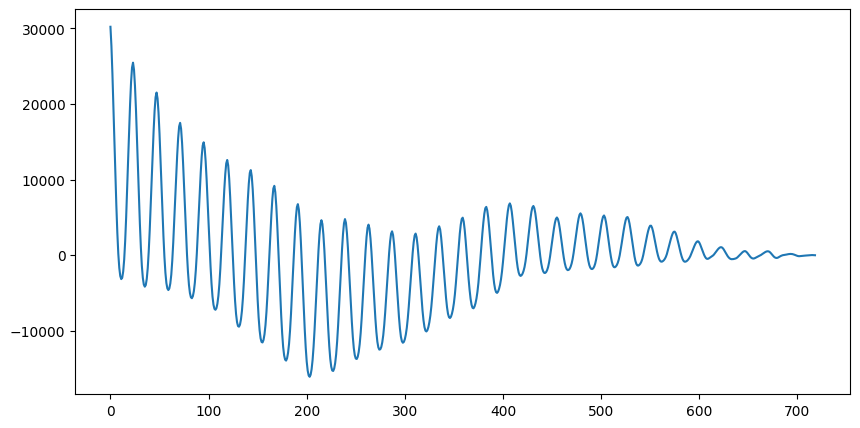

In [12]:
# transformadas para la temperatura
n_data=len(data_salta_temp)
temp_transf = data_salta_temp-data_salta_temp.mean()
temp_transf_cov = np.correlate(temp_transf, temp_transf, mode='Full')[n_data:]
plt.figure(figsize=(10,5))
plt.plot(temp_transf_cov)
plt.plot()

## Correlación

[]

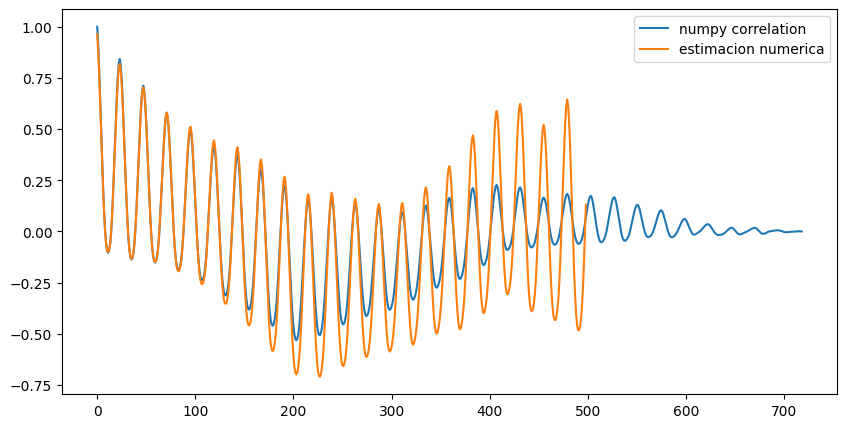

In [27]:
def correl(x, y):
    xm = x.mean()
    ym = y.mean()
    return np.average((x-xm)*(y-ym))/(x.std()*y.std())
lookback = 500
corrs = []
for n in range(1,lookback):
    corrs.append(correl(data_salta_temp[n:], data_salta_temp[:-n]))
# transformadas para la temperatura
temp_transf = (data_salta_temp-data_salta_temp.mean())/data_salta_temp.std()
temp_transf_cor = np.correlate(temp_transf, temp_transf, mode='full')[n_data:]
temp_transf_cor /= temp_transf_cor[0]
plt.figure(figsize=(10,5))
plt.plot(temp_transf_cor, label = 'correlación numpy')
plt.plot(corrs, label = 'estimacion numerica')
plt.legend()
plt.plot()

## Derivada centrada

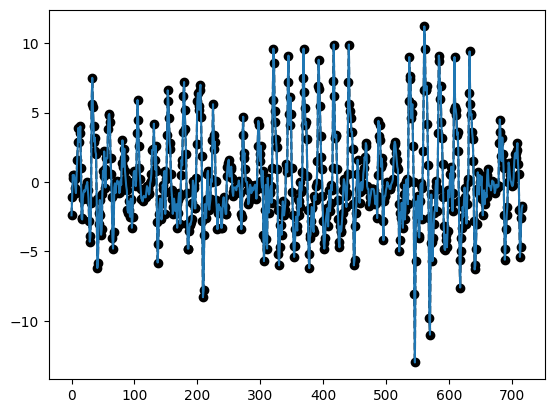

In [83]:
plantilla = np.array([1,0,-1])
derivada = data_salta_temp[2:]-data_salta_temp[:-2]
plt.plot(derivada, 'ko--')
plt.plot(np.convolve(data_salta_temp, plantilla, mode= 'valid'))

# Suavizado Gaussiano

In [92]:
def gauss(x, m, s):
    return np.exp(-(x-m)**2/2/s**2)/np.sqrt(2*np.pi)/s

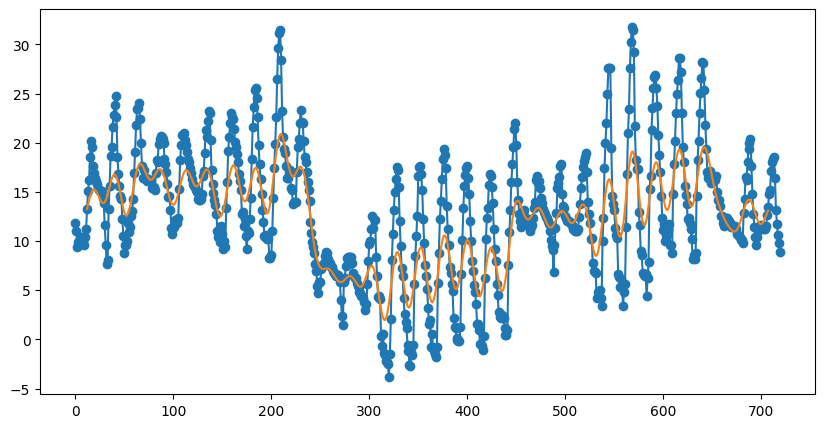

In [120]:
plantilla = gauss(np.arange(25),12,6)
# plt.plot(np.arange(11),plantilla, 'o')
plt.figure(figsize=(10,5))
plt.plot(data_salta_temp, 'o-')
plt.plot(np.arange(plantilla.shape[0]//2,data_salta_temp.shape[0]-plantilla.shape[0]//2),np.convolve(data_salta_temp, plantilla, mode='valid'))

## Derivada Gaussiana

In [130]:
def dgauss(x, m, s):
    return -(x-m)/s * gauss(x,m,s)

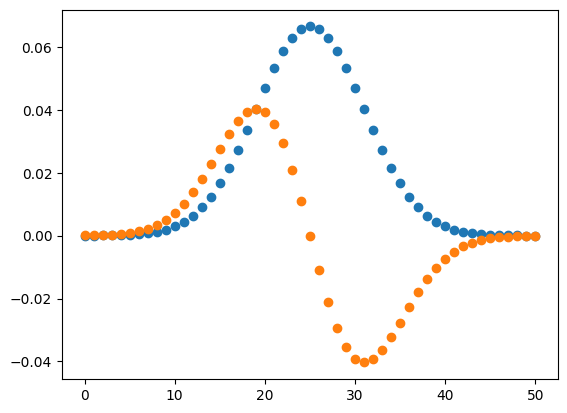

In [163]:
plantilla = dgauss(np.arange(51),25,6)
plt.plot(gauss(np.arange(51),25,6),'o')
plt.plot(dgauss(np.arange(51),25,6),'o')


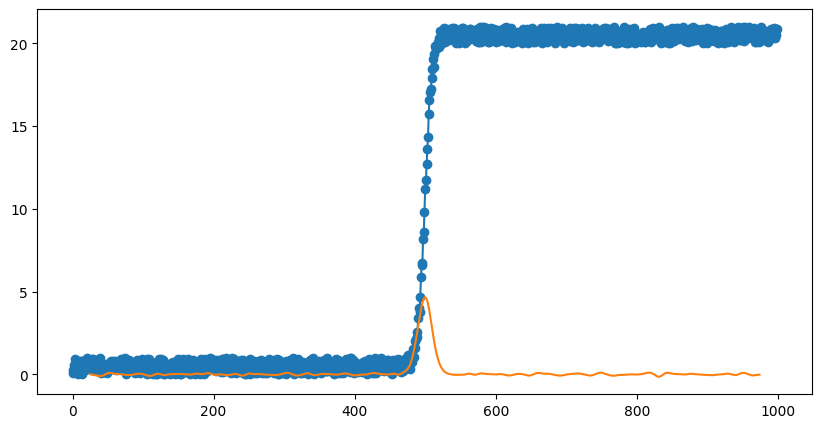

In [164]:
x = np.linspace(-10, 10, 1000) 
z = 1/(1 + np.exp(-10*x)) 
sint = 20*z + np.random.uniform(size=1000)
plt.figure(figsize=(10,5))
plt.plot(sint, 'o-')
plt.plot(np.arange(plantilla.shape[0]//2,sint.shape[0]-plantilla.shape[0]//2),np.convolve(sint, plantilla, mode='valid'))